# Does education Make our Life Longer?

In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pandas.core.frame import DataFrame
from IPython.display import display
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


 ### 1. ensure data types are appropriate and there is no missing data

In [224]:
df = pd.read_csv('/Users/amit/Documents/Code/python/life-expectancy/life-expectancy.csv', dtype={'Country':'category', 'Status':'category'})

n_rows, n_columns = df.shape 
total_data = n_rows * n_columns
print(f'total rows: {n_rows} \ntotal columns: {n_columns} \ntotal data: {total_data}')

df.head()

total rows: 2938 
total columns: 22 
total data: 64636


,Country,Year,Status,Lifeexpectancy,AdultMortality,infantdeaths,Alcohol,percentageexpenditure,HepatitisB,Measles,...,Polio,Totalexpenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness1-19years,thinness5-9years,Incomecompositionofresources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [225]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Country                       2938 non-null   category
 1   Year                          2938 non-null   int64   
 2   Status                        2938 non-null   category
 3   Lifeexpectancy                2928 non-null   float64 
 4   AdultMortality                2928 non-null   float64 
 5   infantdeaths                  2938 non-null   int64   
 6   Alcohol                       2744 non-null   float64 
 7   percentageexpenditure         2938 non-null   float64 
 8   HepatitisB                    2385 non-null   float64 
 9   Measles                       2938 non-null   int64   
 10  BMI                           2904 non-null   float64 
 11  under-fivedeaths              2938 non-null   int64   
 12  Polio                         2919 non-null   fl

- Country's Dtype was originally object, it has been changed to categorical data
- Status's Dtype was originally object, it has been changed to categorical data


In [226]:
print('number of nulls is: ', df.isnull().sum().sum())
df.isnull().sum()

number of nulls is:  2563


Country                           0
Year                              0
Status                            0
Lifeexpectancy                   10
AdultMortality                   10
infantdeaths                      0
Alcohol                         194
percentageexpenditure             0
HepatitisB                      553
Measles                           0
BMI                              34
under-fivedeaths                  0
Polio                            19
Totalexpenditure                226
Diphtheria                       19
HIV/AIDS                          0
GDP                             448
Population                      652
thinness1-19years                34
thinness5-9years                 34
Incomecompositionofresources    167
Schooling                       163
dtype: int64

In [227]:
df_no_nulls = df.dropna(subset=['Incomecompositionofresources', 'Schooling', 'Lifeexpectancy'])

original_rows = len(df)
cleaned_rows = len(df_no_nulls)

print('Original number of rows: ', original_rows)
print('Number of rows after cleaning: ', cleaned_rows)
print('Number of rows removed: ', original_rows - cleaned_rows)

df = df_no_nulls

Original number of rows:  2938
Number of rows after cleaning:  2768
Number of rows removed:  170


### 2. statistical summaries

In [228]:
def summary_stats(dataframe: DataFrame, numeric_only=True, style=True):
    if numeric_only:
        numeric_cols = dataframe.select_dtypes(include=['number']).columns
        summary = dataframe[numeric_cols].describe().T
        summary["variance"] = dataframe[numeric_cols].var()
        if style:
            summary = summary.style.format("{:.2f}").background_gradient(cmap="Oranges", axis=1, subset=summary.columns.drop("count"))
    else:
        numeric_cols = dataframe.select_dtypes(include=['number']).columns
        summary = dataframe.describe(exclude=['number'])
    return summary



numeric_cols_summary = summary_stats(df, style=True)
category_cols_summary = summary_stats(df, numeric_only=False)

display(numeric_cols_summary)
display(category_cols_summary)

,count,mean,std,min,25%,50%,75%,max,variance
Year,2768.00,2007.50,4.61,2000.00,2003.75,2007.50,2011.25,2015.00,21.26
Lifeexpectancy,2768.00,69.35,9.36,36.30,63.50,72.20,75.50,89.00,87.62
AdultMortality,2768.00,163.04,122.95,1.00,73.00,143.50,225.00,723.00,15117.79
infantdeaths,2768.00,29.37,120.26,0.00,0.00,3.00,20.00,1800.00,14461.33
Alcohol,2584.00,4.52,4.01,0.01,0.85,3.70,7.50,17.87,16.06
percentageexpenditure,2768.00,783.11,2039.48,0.00,9.85,78.79,482.90,19479.91,4159485.11
HepatitisB,2259.00,80.94,24.95,2.00,77.00,92.00,97.00,99.00,622.70
Measles,2768.00,2195.33,10555.35,0.00,0.00,15.00,334.50,212183.00,111415501.90
BMI,2736.00,38.51,19.86,1.00,19.38,44.00,56.10,77.60,394.31
under-fivedeaths,2768.00,40.66,163.50,0.00,0.00,4.00,25.00,2500.00,26733.01


,Country,Status
count,2768,2768
unique,173,2
top,Afghanistan,Developing
freq,16,2304


### 3. Outcome and Input Variables
__Outcome variable__: Life expectancy

__Input Variables__:
1. Alcohol
2. BMI
3. Schooling
4. Income composition of resources

### 4. Find and remove outliers

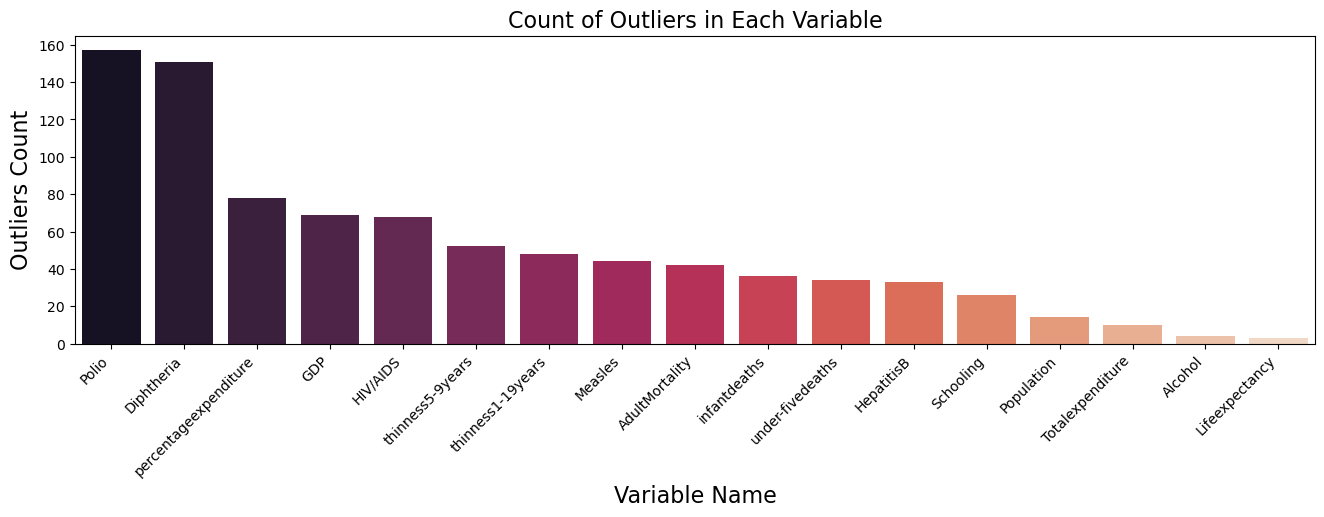

In [229]:
numeric_df = df.select_dtypes(include=['number'])

def find_outliers(df, column):
    mean = df[column].mean()
    std = df[column].std()
    lower_bound, upper_bound = mean - 3 * std, mean + 3 * std
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)].copy()
    outliers['column_name'] = column  # Include column name for identification
    return outliers

def plot_outliers(df):
    all_outliers = pd.concat([find_outliers(df, col) for col in numeric_df.columns])
    
    outliers_count = all_outliers['column_name'].value_counts().reset_index()
    outliers_count.columns = ['column_name', 'outliers_count']
    
    plt.figure(figsize=(16, 4))
    bar_plot = sns.barplot(x='column_name', y='outliers_count', data=outliers_count, palette='rocket')
    plt.title('Count of Outliers in Each Variable', fontsize=16)
    plt.xlabel('Variable Name', fontsize=16)
    plt.ylabel('Outliers Count', fontsize=16)
    plt.xticks(rotation=45, ha='right')

    plt.show()

plot_outliers(df)

In [230]:
def remove_outliers(df, whitelist):
    numeric_df_columns = df.select_dtypes(include=['number']).columns
    outliers_counts = {}

    for col in numeric_df_columns:
        if col in whitelist:
            outliers = find_outliers(df, col)
            outliers_counts[col] = len(outliers)
            
            mean = df[col].mean()
            std = df[col].std()
            lower_bound, upper_bound = mean - 3 * std, mean + 3 * std
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df, outliers_counts

df_cleaned, outliers_counts = remove_outliers(df, ['Alcohol', 'Schooling', 'Lifeexpectancy', 'under-fivedeaths', 'AdultMortality', 'infantdeaths', 'Incomecompositionofresources'])

print(f'Rows before removing outliers: {df.shape[0]}')
print(f'Rows after removing outliers: {df_cleaned.shape[0]}')

Rows before removing outliers: 2768
Rows after removing outliers: 2331


So we got to the point... does schooling really make our life longer?
### 5. test the hypothesis

$$H_0 = \text{Greater education extends life expectancy}$$
$$H_1 = \text{Greater education does not extend life expectancy}$$

#### first test - correlation

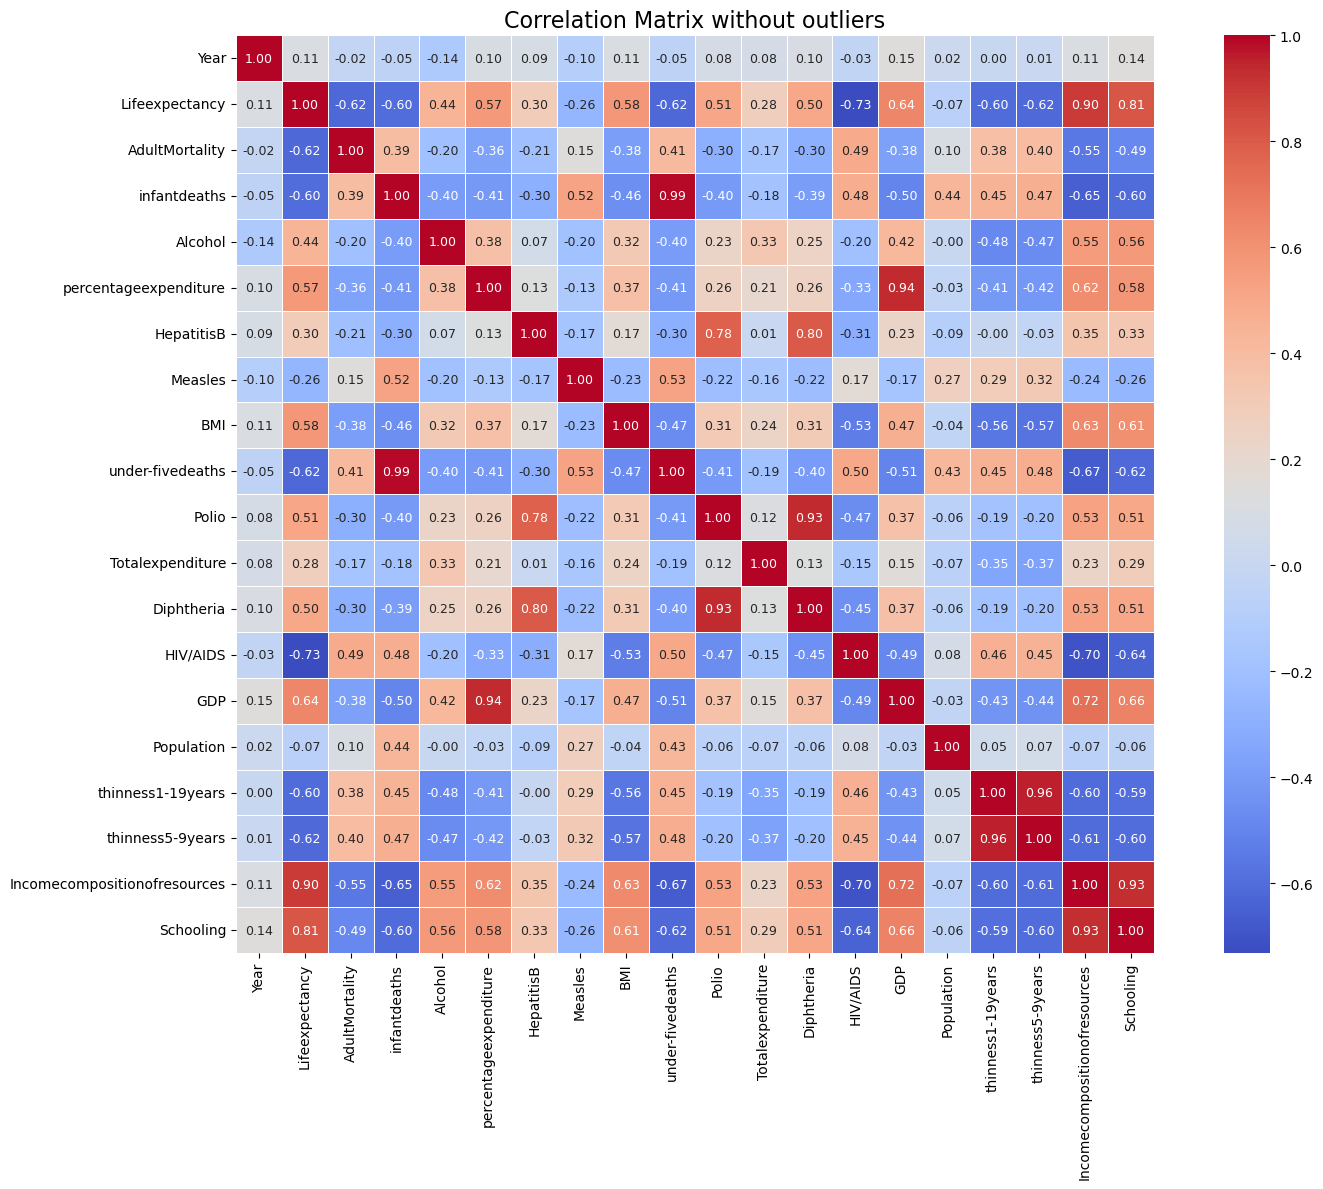

In [231]:
numeric_df_cleaned = df_cleaned.select_dtypes(include=['number'])
corr_matrix_without_outliers = numeric_df_cleaned.corr(method="spearman")

plt.figure(figsize=(16, 12))  # Increase the figure size to make the matrix clearer

sns.heatmap(
    corr_matrix_without_outliers, 
    cmap="coolwarm", 
    linewidths=0.5, 
    annot=True, 
    fmt=".2f", 
    annot_kws={"size": 9},  # Adjust annotation font size
    square=True,
)
plt.title('Correlation Matrix without outliers', fontsize=16)
plt.tight_layout()  # Adjust the layout to fit the suptitle


we can see that there __is__ a correlation between Life expectancy and Schooling, but this does not answer our hypothesis, but it does give us a glimpse of knowledge about the relation between our candidates.

in order to answer our hypothesis we need to understand the distribution of our data to know which tests to take (parametric vs non parametric).

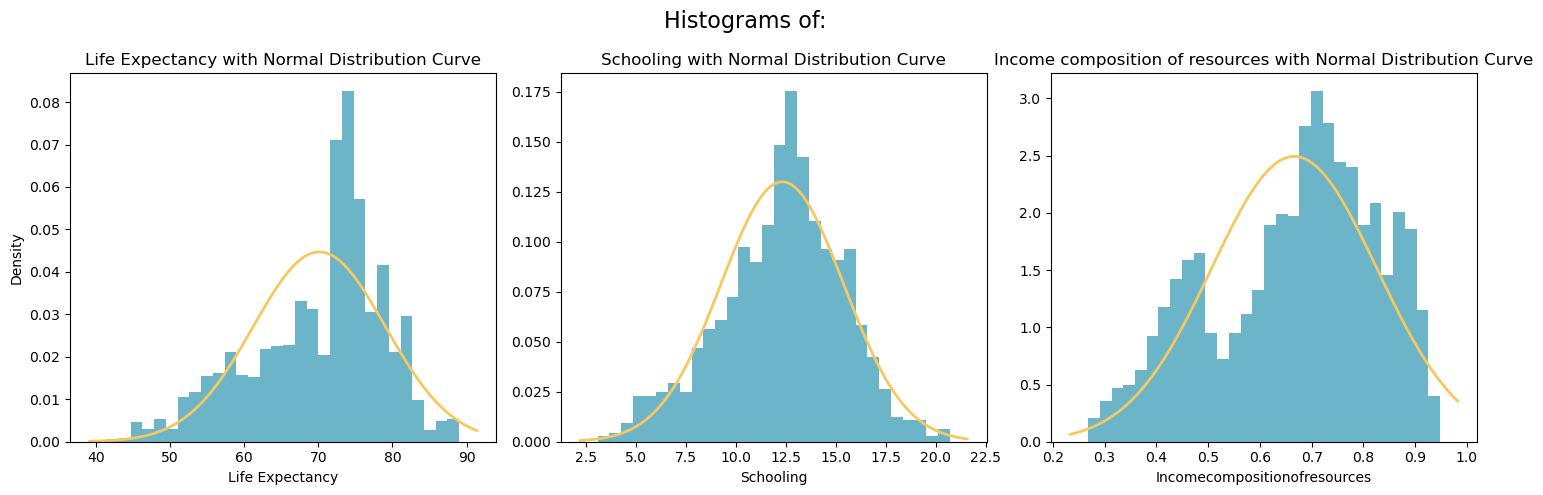

In [232]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

# Plot Life Expectancy distribution
axes[0].hist(df_cleaned['Lifeexpectancy'], bins=30, density=True, alpha=0.6, color='#0b84a5')

xmin, xmax = axes[0].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, df_cleaned['Lifeexpectancy'].mean(), df_cleaned['Lifeexpectancy'].std())
axes[0].plot(x, p, linewidth=2, color='#f6c85f')

axes[0].set_title('Life Expectancy with Normal Distribution Curve', color='black')
axes[0].set_xlabel('Life Expectancy', color='black')
axes[0].set_ylabel('Density', color='black')

axes[1].hist(df_cleaned['Schooling'], bins=30, density=True, alpha=0.6, color='#0b84a5')

xmin, xmax = axes[1].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, df_cleaned['Schooling'].mean(), df_cleaned['Schooling'].std())
axes[1].plot(x, p, linewidth=2, color='#f6c85f')

axes[1].set_title('Schooling with Normal Distribution Curve', color='black')
axes[1].set_xlabel('Schooling', color='black')

axes[2].hist(df_cleaned['Incomecompositionofresources'], bins=30, density=True, alpha=0.6, color='#0b84a5')

xmin, xmax = axes[2].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, df_cleaned['Incomecompositionofresources'].mean(), df_cleaned['Incomecompositionofresources'].std())
axes[2].plot(x, p, linewidth=2, color='#f6c85f')

axes[2].set_title('Income composition of resources with Normal Distribution Curve', color='black')
axes[2].set_xlabel('Incomecompositionofresources', color='black')

plt.suptitle('Histograms of:', fontsize=16, color='black')
plt.tight_layout()
plt.show()

In these histograms, we can definitely see that Life expectancy is not normal because it is not centred against the middle,<br/>
but Schooling really does fit the normal distribution.<br/><br/>
so let's test it!

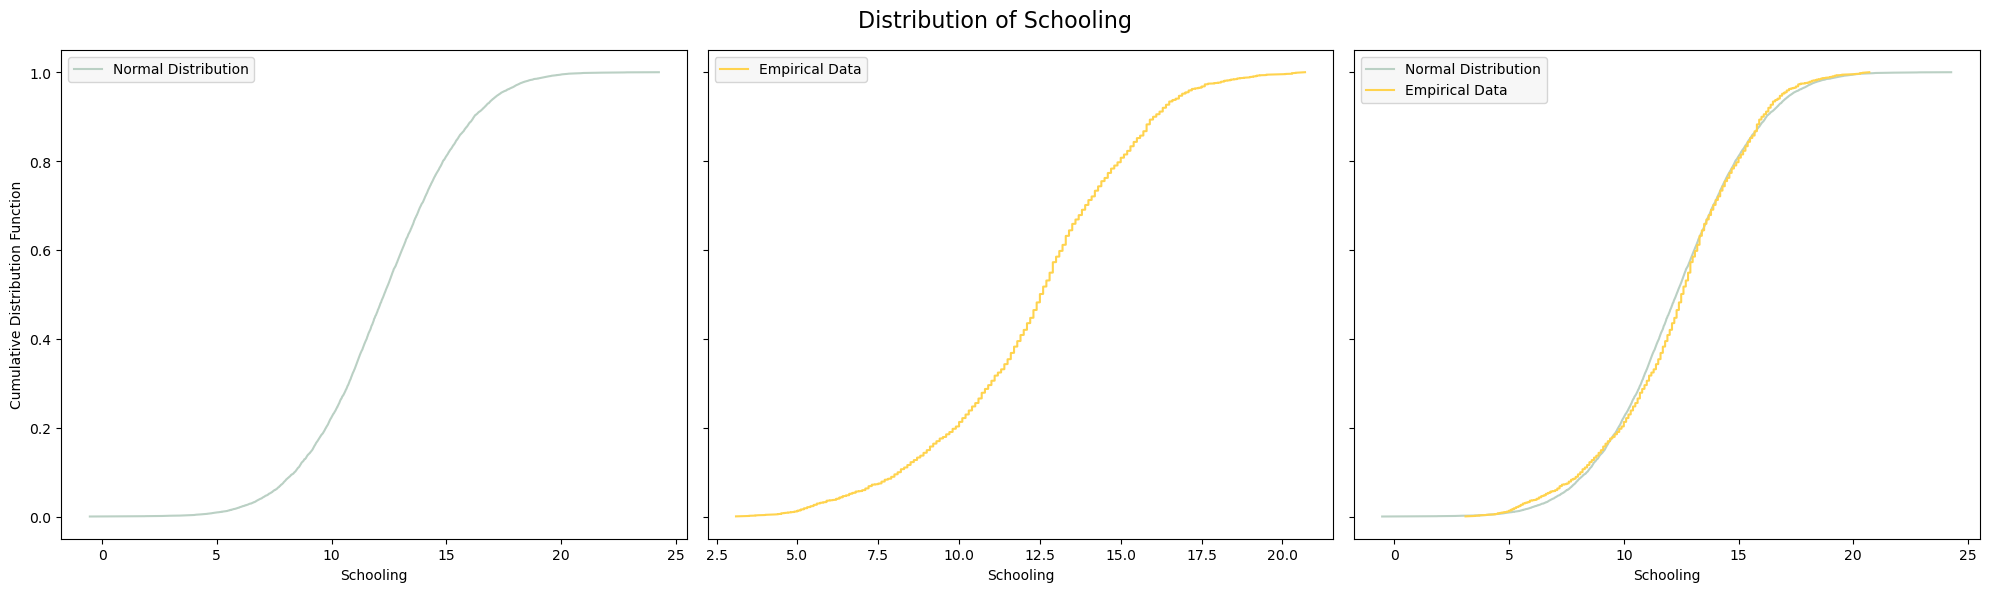

NormaltestResult(statistic=32.792848657807845, pvalue=7.570479556514286e-08)
KstestResult(statistic=0.051640930158020404, pvalue=7.655748383616585e-06, statistic_location=11.6, statistic_sign=-1)


In [233]:
def ecdf(data):
    length = len(data)
    x = np.sort(data)
    y = np.arange(1, length+1) / length
    return x, y

# Generate samples for the normal distribution
samples = np.random.normal(np.mean(df_cleaned["Schooling"]), np.std(df_cleaned["Schooling"]), size=10000)
x_theor, y_theor = ecdf(samples)

x_emp, y_emp = ecdf(df_cleaned["Schooling"])

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
    
# Plot theoretical distribution
axes[0].plot(x_theor, y_theor, label='Normal Distribution', color='#bad0c4')
axes[0].set_xlabel("Schooling", color='black')
axes[0].set_ylabel("Cumulative Distribution Function", color='black')
axes[0].legend(facecolor='whitesmoke')

# Plot empirical data
axes[1].plot(x_emp, y_emp, label='Empirical Data', color='#ffd34e')
axes[1].set_xlabel("Schooling", color='black')
axes[1].legend(facecolor='whitesmoke')

axes[2].plot(x_theor, y_theor, label='Normal Distribution', color='#bad0c4')
axes[2].plot(x_emp, y_emp, label='Empirical Data', color='#ffd34e')
axes[2].set_xlabel("Schooling", color='black')
axes[2].legend(facecolor='whitesmoke')

fig.suptitle('Distribution of Schooling' , fontsize=16)

plt.tight_layout()
plt.show()

print(stats.normaltest(df_cleaned["Schooling"]))
print(stats.kstest(df_cleaned["Schooling"], 'norm', args=(df_cleaned["Schooling"].mean(), df_cleaned["Schooling"].std())))

our p-value result is < 0.05 thus, we will reject our null hypothesis:<br/>
- __Schooling is not normally distributed__

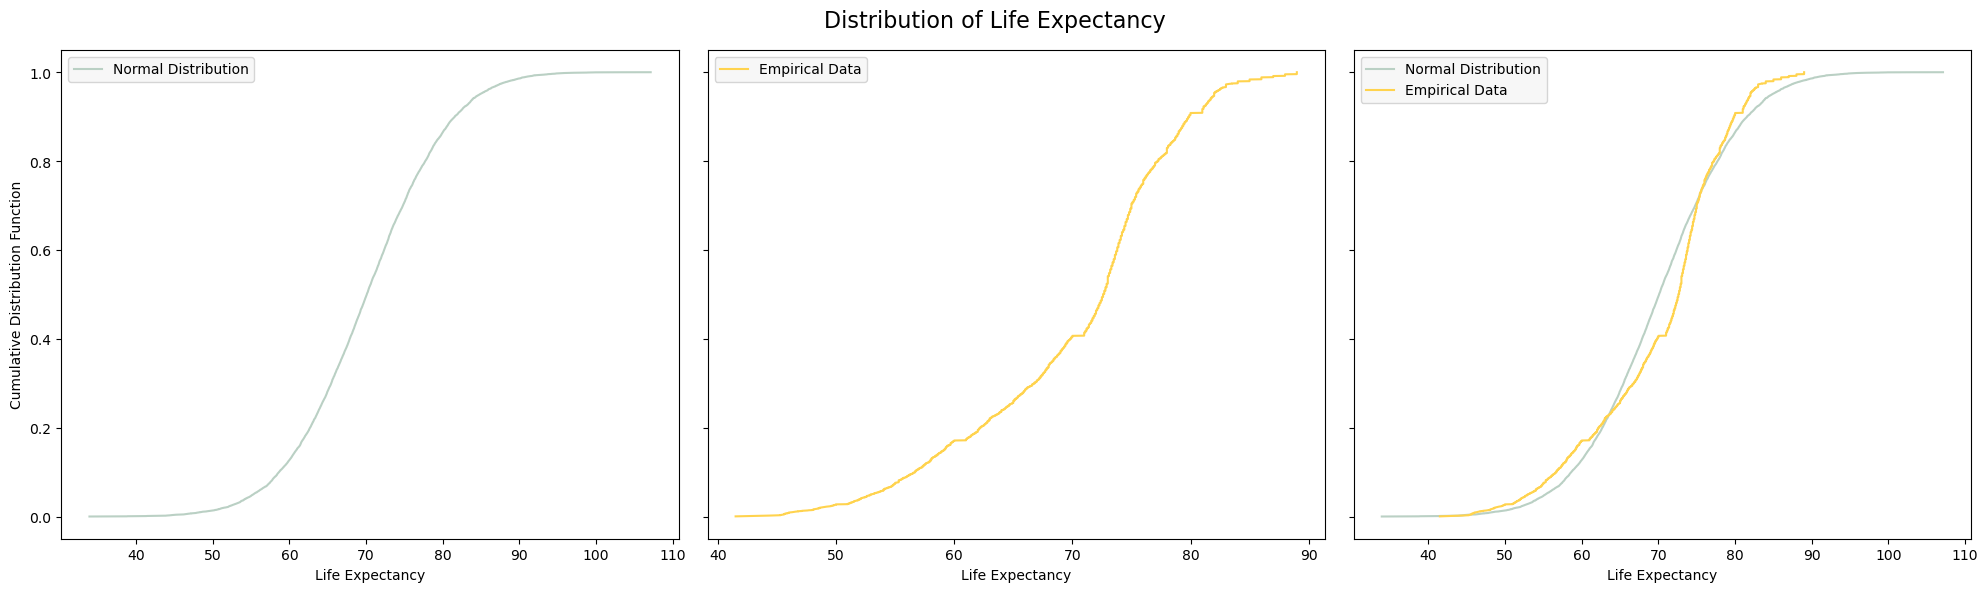

NormaltestResult(statistic=145.93221903901673, pvalue=2.047487550328789e-32)
KstestResult(statistic=0.13244425236084656, pvalue=4.076027259259976e-36, statistic_location=71.0, statistic_sign=-1)


In [234]:
# Generate samples for the normal distribution
samples = np.random.normal(np.mean(df_cleaned["Lifeexpectancy"]), np.std(df_cleaned["Lifeexpectancy"]), size=10000)
x_theor, y_theor = ecdf(samples)

x_emp, y_emp = ecdf(df_cleaned["Lifeexpectancy"])

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Plot theoretical distribution
axes[0].plot(x_theor, y_theor, label='Normal Distribution', color='#bad0c4')
axes[0].set_xlabel("Life Expectancy", color='black')
axes[0].set_ylabel("Cumulative Distribution Function", color='black')
axes[0].legend(facecolor='whitesmoke')

# Plot empirical data
axes[1].plot(x_emp, y_emp, label='Empirical Data', color='#ffd34e')
axes[1].set_xlabel("Life Expectancy", color='black')
axes[1].legend(facecolor='whitesmoke')

axes[2].plot(x_theor, y_theor, label='Normal Distribution', color='#bad0c4')
axes[2].plot(x_emp, y_emp, label='Empirical Data', color='#ffd34e')
axes[2].set_xlabel("Life Expectancy", color='black')
axes[2].legend(facecolor='whitesmoke')

fig.suptitle('Distribution of Life Expectancy' , fontsize=16)

plt.tight_layout()
plt.show()

print(stats.normaltest(df_cleaned["Lifeexpectancy"]))
print(stats.kstest(df_cleaned["Lifeexpectancy"], 'norm', args=(df_cleaned["Lifeexpectancy"].mean(), df_cleaned["Lifeexpectancy"].std())))

our p-value result is << 0.05 thus, we will reject our null hypothesis:<br/>
- __Life expectancy is not normally distributed__
<br/>
<br/>
#### In summary:

In [235]:
results = []

for column in ['Lifeexpectancy', 'Incomecompositionofresources', 'Schooling']:
    # Shapiro-Wilk test
    shapiro_stat, shapiro_p = stats.shapiro(df_cleaned[column])
    results.append([column, 'Shapiro-Wilk', shapiro_stat, shapiro_p])
    
    # Kolmogorov-Smirnov test
    ks_stat, ks_p = stats.kstest(df_cleaned[column], 'norm', args=(df_cleaned[column].mean(), df_cleaned[column].std()))
    results.append([column, 'Kolmogorov-Smirnov', ks_stat, ks_p])
    
    # Cramér-von Mises test
    cvm_result = stats.cramervonmises(df_cleaned[column], 'norm', args=(df_cleaned[column].mean(), df_cleaned[column].std()))
    results.append([column, 'Cramér-von Mises', cvm_result.statistic, cvm_result.pvalue])

results_df = pd.DataFrame(results, columns=['Column', 'Test', 'Statistic', 'P-value'])
print(results_df)


                         Column                Test  Statistic       P-value
0                Lifeexpectancy        Shapiro-Wilk   0.956233  6.718505e-26
1                Lifeexpectancy  Kolmogorov-Smirnov   0.132444  4.076027e-36
2                Lifeexpectancy    Cramér-von Mises   7.684377  1.104667e-09
3  Incomecompositionofresources        Shapiro-Wilk   0.961610  2.185852e-24
4  Incomecompositionofresources  Kolmogorov-Smirnov   0.077606  1.172984e-12
5  Incomecompositionofresources    Cramér-von Mises   4.294251  1.052205e-10
6                     Schooling        Shapiro-Wilk   0.990988  6.997771e-11
7                     Schooling  Kolmogorov-Smirnov   0.051641  7.655748e-06
8                     Schooling    Cramér-von Mises   1.089889  1.514705e-03


because we are trying to find a correlation between non-normal-distribution datasets, we can't use parametric test.
<br/>
so in order to test the hypothesis, we will use few non-parametric tests:

#### Pearson's correlation 

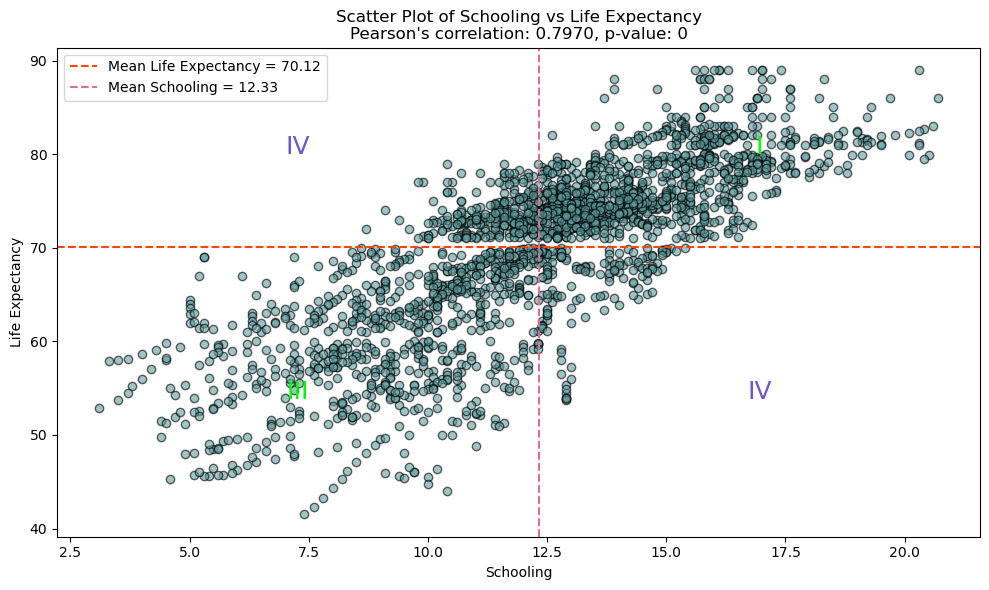

In [236]:
corr, p_value = stats.pearsonr(df_cleaned['Schooling'], df_cleaned['Lifeexpectancy'])

plt.figure(figsize=(10, 6))
plt.scatter(df_cleaned['Schooling'], df_cleaned['Lifeexpectancy'], alpha=0.6, color='cadetblue', edgecolor='k')

# Add mean lines
mean_schooling = df_cleaned['Schooling'].mean()
mean_lifeexpectancy = df_cleaned['Lifeexpectancy'].mean()

plt.axhline(mean_lifeexpectancy, color='orangered', linestyle='--', label=f'Mean Life Expectancy = {mean_lifeexpectancy:.2f}')
plt.axvline(mean_schooling, color='palevioletred', linestyle='--', label=f'Mean Schooling = {mean_schooling:.2f}')

plt.xlabel('Schooling')
plt.ylabel('Life Expectancy')
plt.title(f'Scatter Plot of Schooling vs Life Expectancy\nPearson\'s correlation: {corr:.4f}, p-value: {p_value:.0f}')
plt.legend()

xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

# Midpoints
x_mid_left = (xmin + mean_schooling) / 2
x_mid_right = (xmax + mean_schooling) / 2
y_mid_bottom = (ymin + mean_lifeexpectancy) / 2
y_mid_top = (ymax + mean_lifeexpectancy) / 2

plt.text(x_mid_left, y_mid_top, 'IV', fontsize=18, ha='center', va='center', color='slateblue')
plt.text(x_mid_right, y_mid_top, 'I', fontsize=18, ha='center', va='center', color='lime')
plt.text(x_mid_left, y_mid_bottom, 'III', fontsize=18, ha='center', va='center', color='lime')
plt.text(x_mid_right, y_mid_bottom, 'IV', fontsize=18, ha='center', va='center', color='slateblue')

plt.tight_layout()
plt.show()

Pearson's correlation coefficient is a value between -1, to 1 that indicates the correlation/dependency between two variables, where:
- 1 means a perfect positive relation
- 0 means no relation
- -1 means a perfect negative relation

<br/>
we can see that most of our data is in quarters I & III, which means that pearson's correlation coefficient is going to be positive (of course we already calculated it...)
<br/>
our coefficient is 0.7276 which indicates high positive correlation, meaning:

$$ \text{higher schooling} \longrightarrow \text{higher life expectancy} $$

#### Spearman's correlation 

In [237]:
corr, p_value = stats.spearmanr(df_cleaned['Schooling'], df_cleaned['Lifeexpectancy'])
print(f"Spearman's correlation: {corr}, p-value: {p_value}")

Spearman's correlation: 0.8112891694835136, p-value: 0.0


#### Linear regression
According to Pearson's coefficient there is a correlation between Schooling and Life expectancy, so in order to find a prediction formula, we will use linear regression.

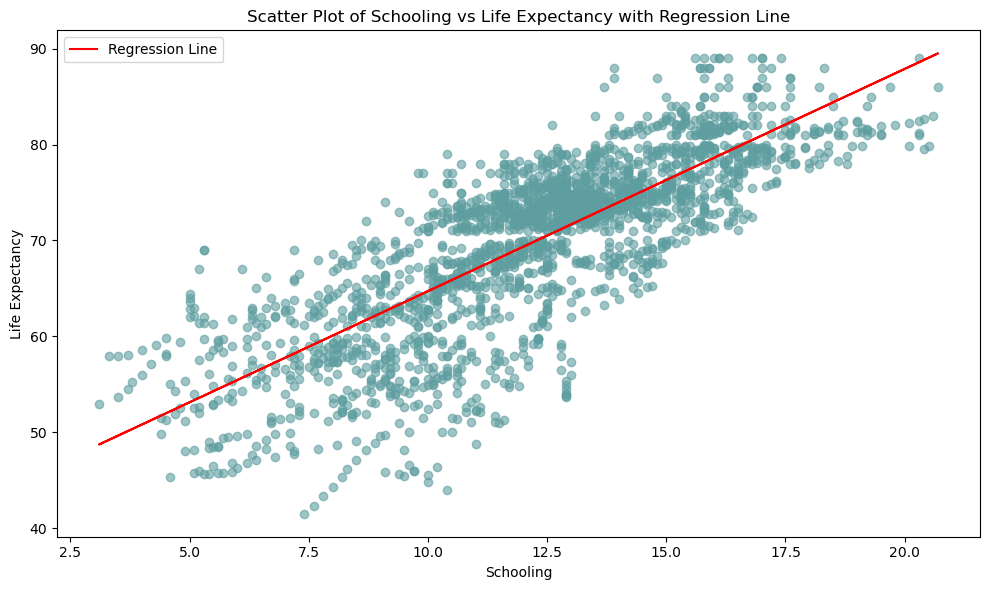

In [238]:
slope, intercept = np.polyfit(df_cleaned['Schooling'], df_cleaned['Lifeexpectancy'], 1)

plt.figure(figsize=(10, 6))
plt.scatter(df_cleaned['Schooling'], df_cleaned['Lifeexpectancy'], alpha=0.6, color='cadetblue')
plt.plot(df_cleaned['Schooling'], slope * df_cleaned['Schooling'] + intercept, color='r', label='Regression Line') #min squared

plt.xlabel('Schooling')
plt.ylabel('Life Expectancy')
plt.title('Scatter Plot of Schooling vs Life Expectancy with Regression Line')
plt.legend()

plt.tight_layout()
plt.show()

The data scatter does seem to follow a linear regression, so let's calculate the linear regression equation

In [239]:
import warnings
from IPython.display import Markdown
warnings.filterwarnings('ignore', category=UserWarning, message='X does not have valid feature names')


model = LinearRegression()

model.fit(df_cleaned[['Schooling']], df_cleaned['Lifeexpectancy'])

intercept, coef = model.intercept_, model.coef_[0]

markdown_text = f"""
$$ \\text{{Prediction equation:}}\\newline\\text{{Life expectancy}} = {intercept:.2f} + {coef:.2f} \\times \\text{{Schooling}} $$
"""
Markdown(markdown_text)



$$ \text{Prediction equation:}\newline\text{Life expectancy} = 41.53 + 2.32 \times \text{Schooling} $$


In [240]:
def predict_life_expectancy(schooling):
    return model.predict([[schooling]]) # type: ignore

print(f'Predicted life expectancy for schooling of 15 years (highschool + first degree): {predict_life_expectancy(15)[0]:.2f}')
print(f'Predicted life expectancy for schooling of 17 years (highschool + first degree + second degree): {predict_life_expectancy(18)[0]:.2f}')
print('\nguess it is a good thing that we are here...')

Predicted life expectancy for schooling of 15 years (highschool + first degree): 76.31
Predicted life expectancy for schooling of 17 years (highschool + first degree + second degree): 83.26

guess it is a good thing that we are here...


A relation between schooling and life expectancy is proven, but why is it?
<br/>
does higher schooling predicts high income which affects life expectancy for the good?
<br/><br/>
We have another interesting column in our dataset, __Income composition of resources__:
<br/>
Human Development Index in terms of income composition of resources (index ranging from 0 to 1) - higher income
<br/>
<br/>
let's try and find a connection between all three...
$$ \text{higher education} \longrightarrow \text{higher income} \longrightarrow \text{higher life expectancy} ?$$
but this actually makes sense!
<br/>
<br/>
- Education equips individuals with knowledge about healthy lifestyles, disease prevention, and the importance of regular medical care, improving overall health and life expectancy.
<br/>
<br/>
- Higher income individuals can afford medications and advanced medical procedures, which contribute to better health outcomes and longer life expectancy.
<br/>
<br/>
- Higher income can minimize financial stress and provide resources for leisure activities, exercise, and relaxation.
Lower stress levels and healthier lifestyle choices, such as balanced diets and physical activity therefore extending life expectancy.
<br/>

theory aside, let's test it.

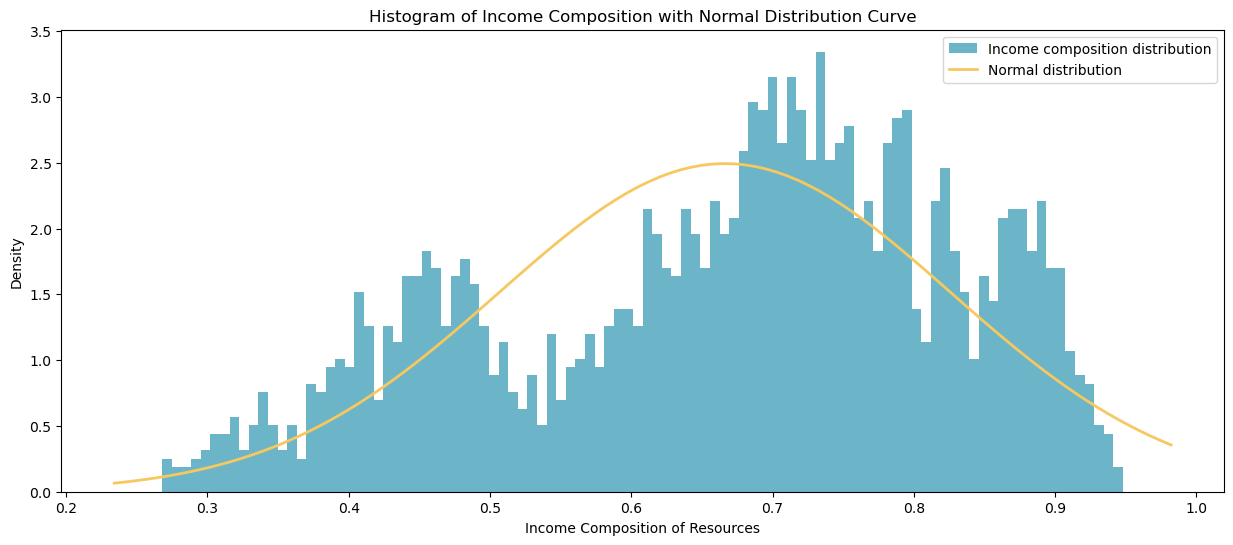

NormaltestResult(statistic=201.56672758696334, pvalue=1.6995785324842727e-44)
KstestResult(statistic=0.0776059763709454, pvalue=1.1729838228709814e-12, statistic_location=0.673, statistic_sign=-1)


In [241]:
plt.figure(figsize=(15, 6))

# Plot Life Expectancy distribution
plt.hist(df_cleaned['Incomecompositionofresources'], bins=100, density=True, alpha=0.6, color='#0b84a5', label='Income composition distribution')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, df_cleaned['Incomecompositionofresources'].mean(), df_cleaned['Incomecompositionofresources'].std())
plt.plot(x, p, linewidth=2, color='#f6c85f', label='Normal distribution')
plt.xlabel('Income Composition of Resources', color='black')
plt.ylabel('Density', color='black')
plt.legend()

plt.title('Histogram of Income Composition with Normal Distribution Curve', color='black')
plt.show()

print(stats.normaltest(df_cleaned["Incomecompositionofresources"]))
print(stats.kstest(df_cleaned["Incomecompositionofresources"], 'norm', args=(df_cleaned["Incomecompositionofresources"].mean(), df_cleaned["Incomecompositionofresources"].std())))

our p-value result is 8.261769255450045e-09 which is << 0.05 thus, we will reject our null hypothesis:<br/>
- __Income Composition of Resources is not normally distributed__

so again, we will use a-parametric tests.

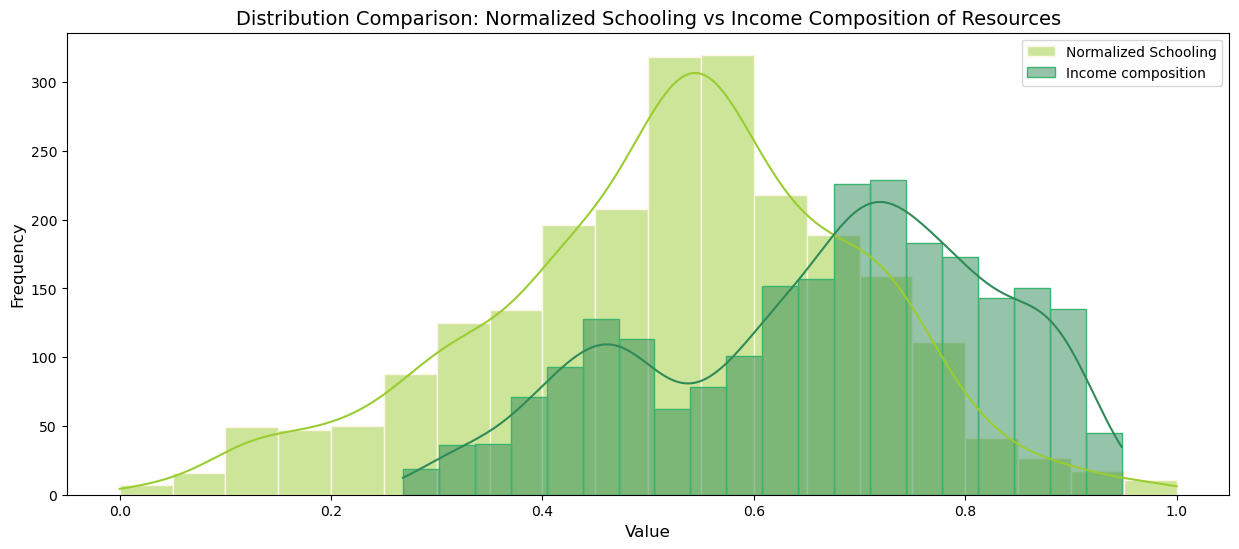

In [242]:
from sklearn.preprocessing import MinMaxScaler
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

observed = df_cleaned['Schooling'].to_numpy()
expected = df_cleaned['Incomecompositionofresources'].to_numpy()

#normalize schooling so both column values will differ from 0 to 1
scaler = MinMaxScaler()
normalized_schooling = scaler.fit_transform(observed.reshape(-1, 1)).flatten()

plt.figure(figsize=(15, 6))
sns.histplot(normalized_schooling, kde=True, bins=20, color='yellowgreen', edgecolor='oldlace', label='Normalized Schooling')
sns.histplot(expected, kde=True, bins=20, color='seagreen', edgecolor='mediumseagreen', label='Income composition')
plt.title('Distribution Comparison: Normalized Schooling vs Income Composition of Resources', fontsize= 14)
plt.xlabel('Value', fontsize= 12)
plt.ylabel('Frequency', fontsize= 12)
plt.legend()
plt.show()


the graphs are a lot alike, they just need some adjustment so its easier to see, and as we know, movement does not affect any correlation

We can see that the only statistically significant difference between the __expected frequencies__ (Income composition) and the __observed__
(schooling) is near 0.3 (near the word imperfect) but other than that, they seem pretty dependant on one another, so let's perform chi-squared

#### Chi - squared test

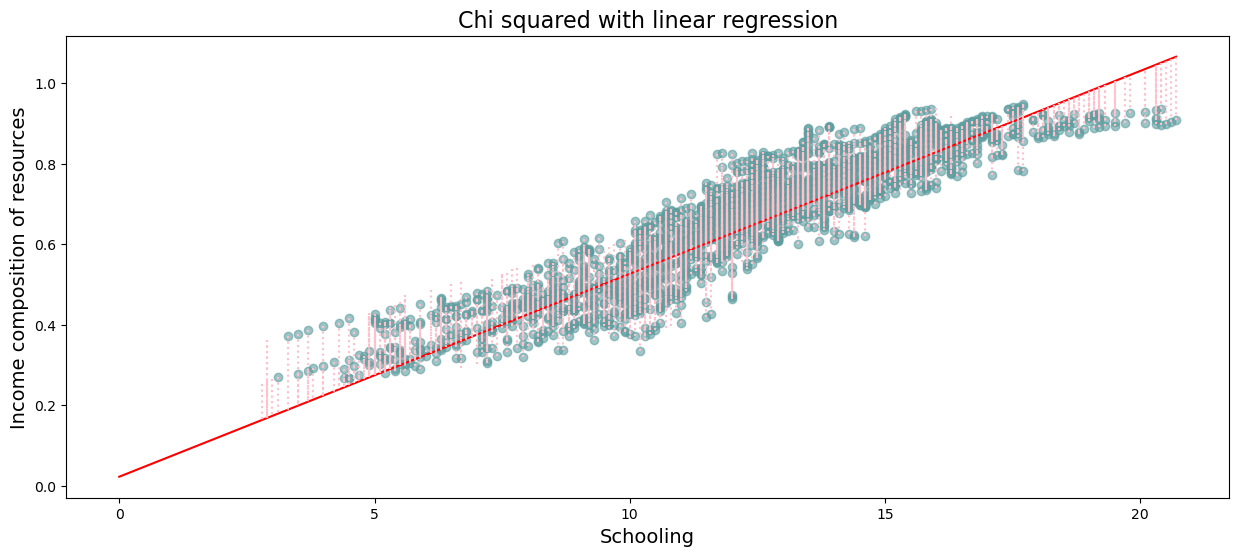

In [243]:
from scipy.optimize import curve_fit

def toLinearFunc(x, a, b):
    return a * x + b

df = df.reset_index(drop=True)

initialParameters = np.array([1.0, 1.0])

fittedParameters, pcov = curve_fit(toLinearFunc, df['Schooling'], df['Incomecompositionofresources'], p0=initialParameters)

modelPredictions = toLinearFunc(df['Schooling'], *fittedParameters) 

plt.figure(figsize=(15, 6))
plt.scatter(df_cleaned['Schooling'], df_cleaned['Incomecompositionofresources'], alpha=0.6, color='cadetblue')
plt.title("Chi squared with linear regression", fontsize=16)
plt.xlabel("Schooling", fontsize=14)
plt.ylabel("Income composition of resources", fontsize=14)

xModel = np.linspace(df['Schooling'].min(), df['Schooling'].max(), 100)
yModel = toLinearFunc(xModel, *fittedParameters)
plt.plot(xModel, yModel, color='red')

for i in range(len(df)):
    lineXdata = (df.loc[i, 'Schooling'], df.loc[i, 'Schooling']) # same X
    lineYdata = (df.loc[i, 'Incomecompositionofresources'], modelPredictions[i]) # different Y
    if lineYdata[0] != 0 and lineYdata[1] != 0:
        plt.plot(lineXdata, lineYdata, color='pink', linestyle='dotted')

plt.show()


In [244]:
contingency_table = pd.crosstab(df_cleaned['Schooling'], df_cleaned['Incomecompositionofresources'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi-squared: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")


Chi-squared: 132174.44588643825
P-value: 0.0
Degrees of freedom: 99330


our p-value is 0, meaning that there is no statistically significant difference between schooling and income composition
<br/>
so it proves that schooling and income composition are dependant on each other, so let's apply linear regression to visually see the relation

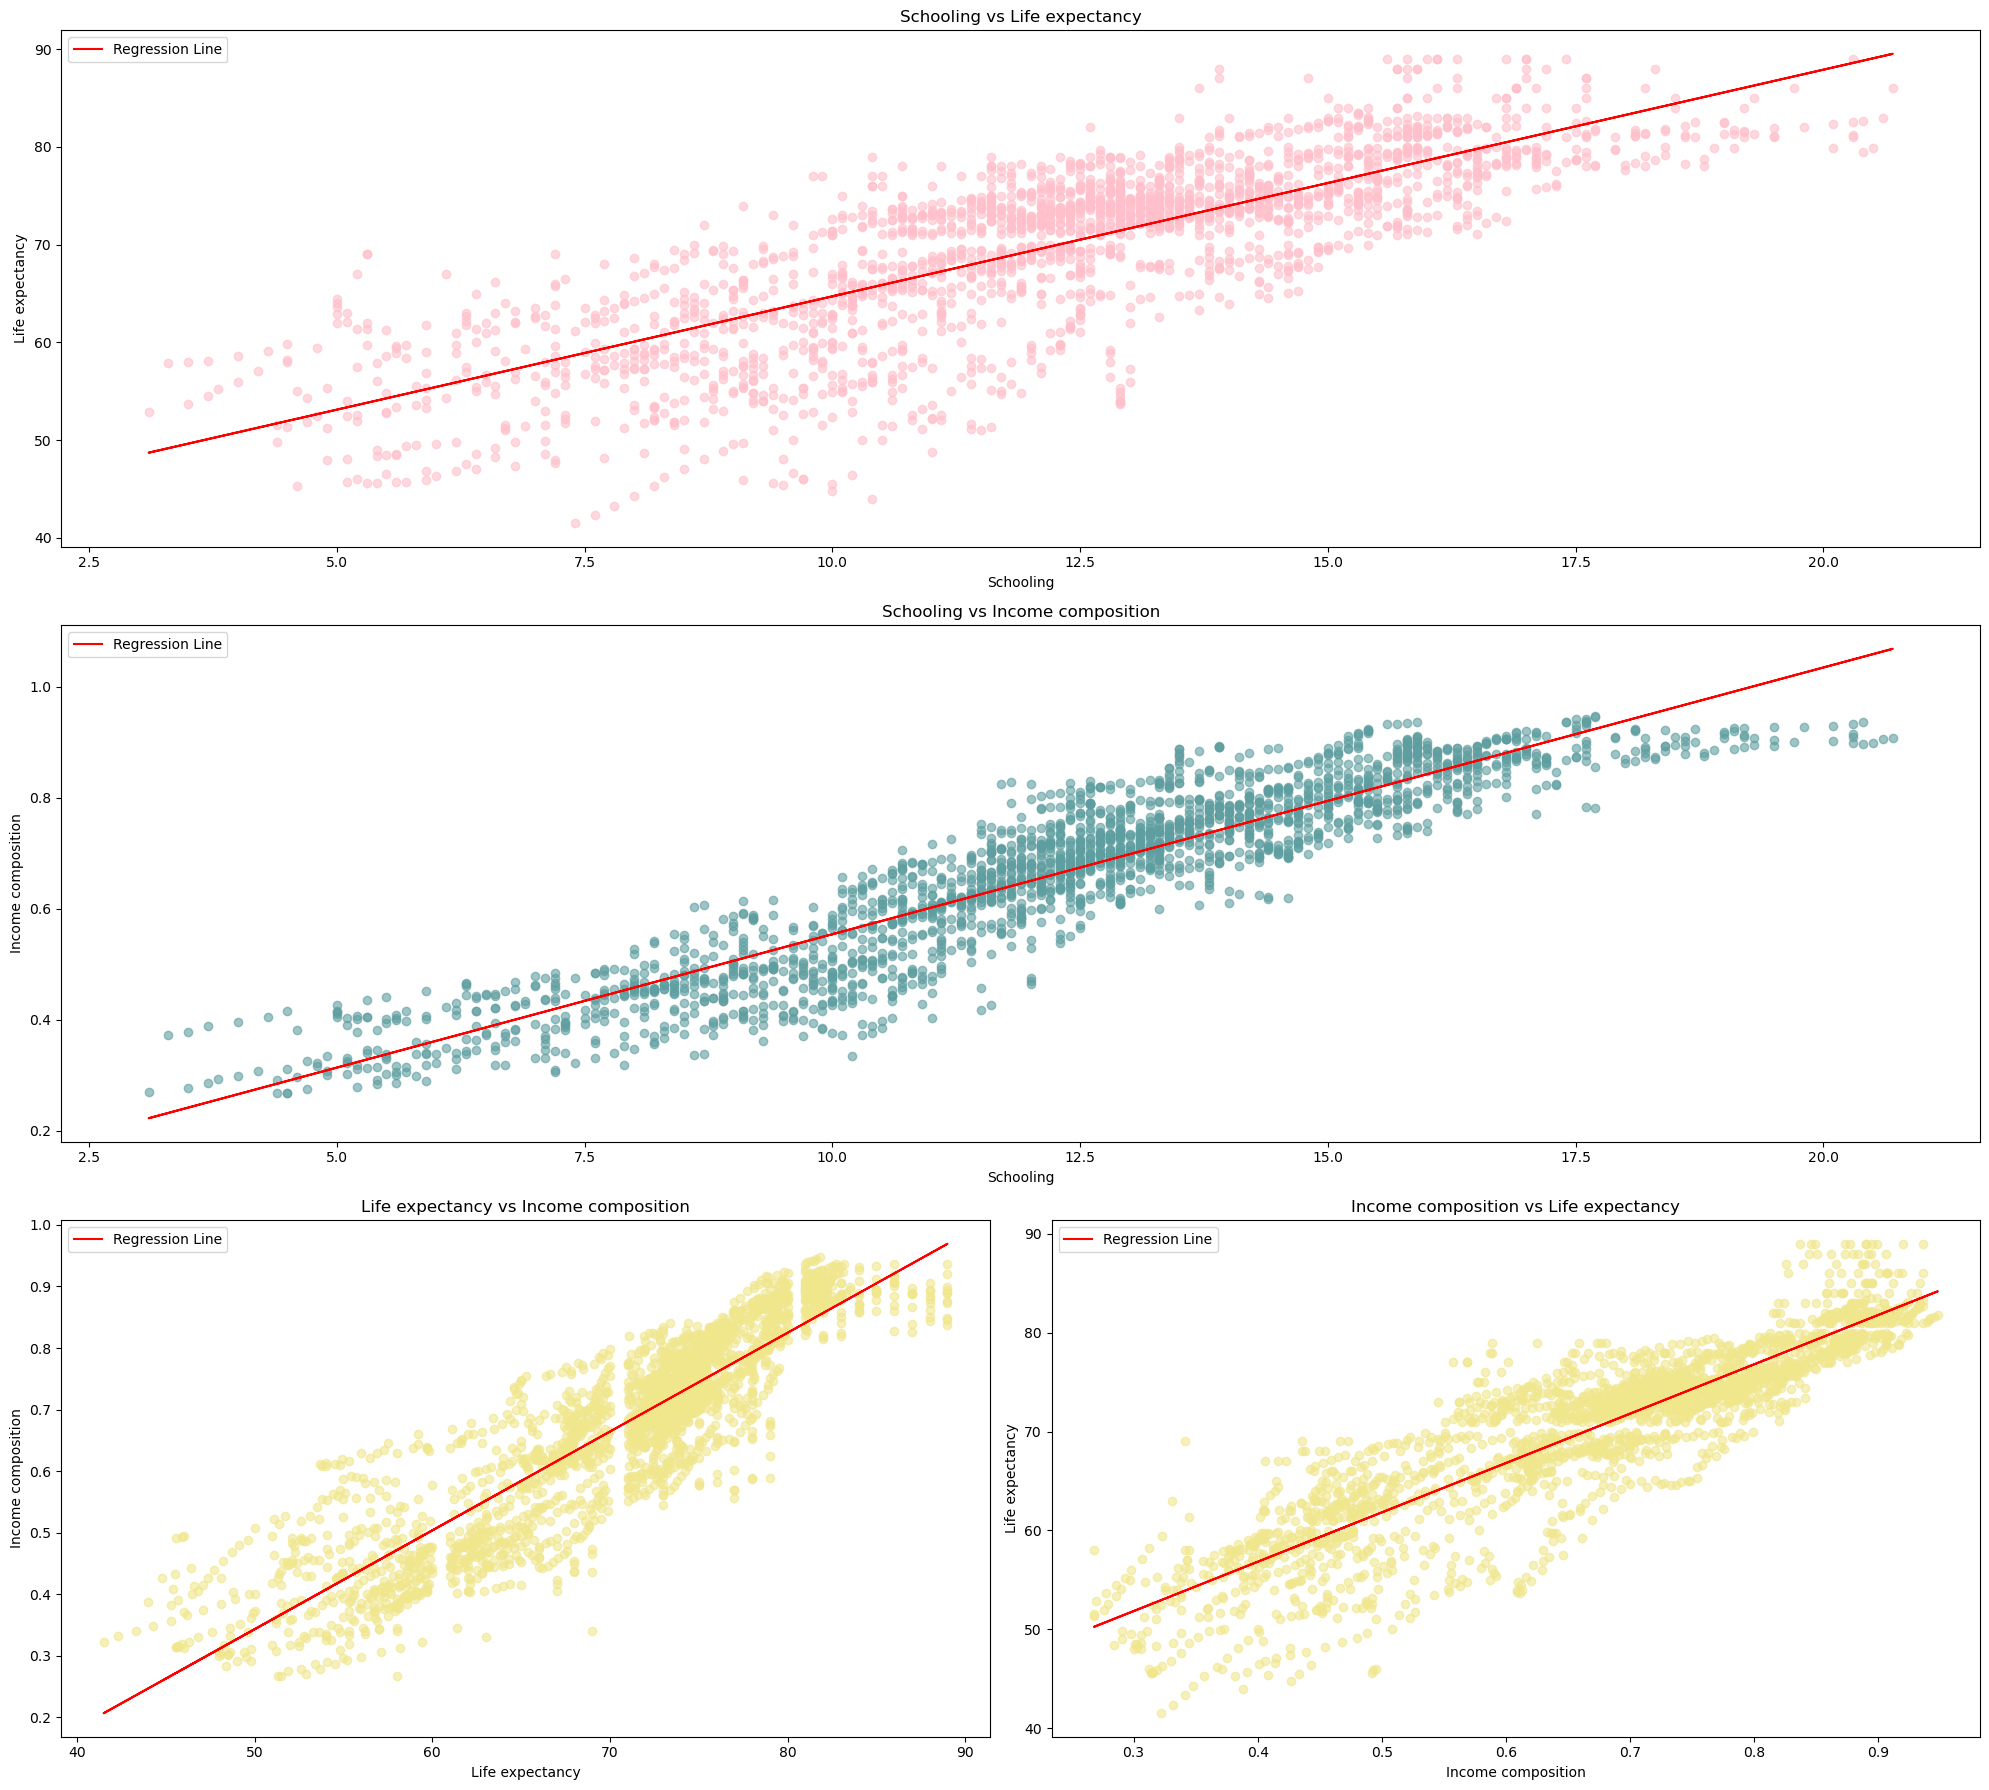

In [245]:
fig = plt.figure(figsize=(20, 18))
gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1])

ax1 = fig.add_subplot(gs[0, :])
ax1.tick_params(colors='black', which='both')

slope, intercept = np.polyfit(df_cleaned['Schooling'], df_cleaned['Lifeexpectancy'], 1)
ax1.scatter(df_cleaned['Schooling'], df_cleaned['Lifeexpectancy'], alpha=0.6, color='pink')
ax1.plot(df_cleaned['Schooling'], slope * df_cleaned['Schooling'] + intercept, color='r', label='Regression Line')
ax1.set_xlabel('Schooling', color='black')
ax1.set_ylabel('Life expectancy', color='black')
ax1.set_title('Schooling vs Life expectancy', color='black')
ax1.legend()

ax2 = fig.add_subplot(gs[1, :])
ax2.tick_params(colors='black', which='both')

slope, intercept = np.polyfit(df_cleaned['Schooling'], df_cleaned['Incomecompositionofresources'], 1)
ax2.scatter(df_cleaned['Schooling'], df_cleaned['Incomecompositionofresources'], alpha=0.6, color='cadetblue')
ax2.plot(df_cleaned['Schooling'], slope * df_cleaned['Schooling'] + intercept, color='r', label='Regression Line')
ax2.set_xlabel('Schooling', color='black')
ax2.set_ylabel('Income composition', color='black')
ax2.set_title('Schooling vs Income composition', color='black')
ax2.legend()

ax3 = fig.add_subplot(gs[2, 0])
ax3.tick_params(colors='black', which='both')

slope, intercept = np.polyfit(df_cleaned['Lifeexpectancy'], df_cleaned['Incomecompositionofresources'], 1)
ax3.scatter(df_cleaned['Lifeexpectancy'], df_cleaned['Incomecompositionofresources'], alpha=0.6, color='khaki')
ax3.plot(df_cleaned['Lifeexpectancy'], slope * df_cleaned['Lifeexpectancy'] + intercept, color='r', label='Regression Line')
ax3.set_xlabel('Life expectancy', color='black')
ax3.set_ylabel('Income composition', color='black')
ax3.set_title('Life expectancy vs Income composition', color='black')
ax3.legend()

ax4 = fig.add_subplot(gs[2, 1])
ax4.tick_params(colors='black', which='both')

slope, intercept = np.polyfit(df_cleaned['Incomecompositionofresources'], df_cleaned['Lifeexpectancy'], 1)
ax4.scatter(df_cleaned['Incomecompositionofresources'], df_cleaned['Lifeexpectancy'], alpha=0.6, color='khaki')
ax4.plot(df_cleaned['Incomecompositionofresources'], slope * df_cleaned['Incomecompositionofresources'] + intercept, color='r', label='Regression Line')
ax4.set_xlabel('Income composition', color='black')
ax4.set_ylabel('Life expectancy', color='black')
ax4.set_title('Income composition vs Life expectancy', color='black')
ax4.legend()

plt.tight_layout()
plt.show()


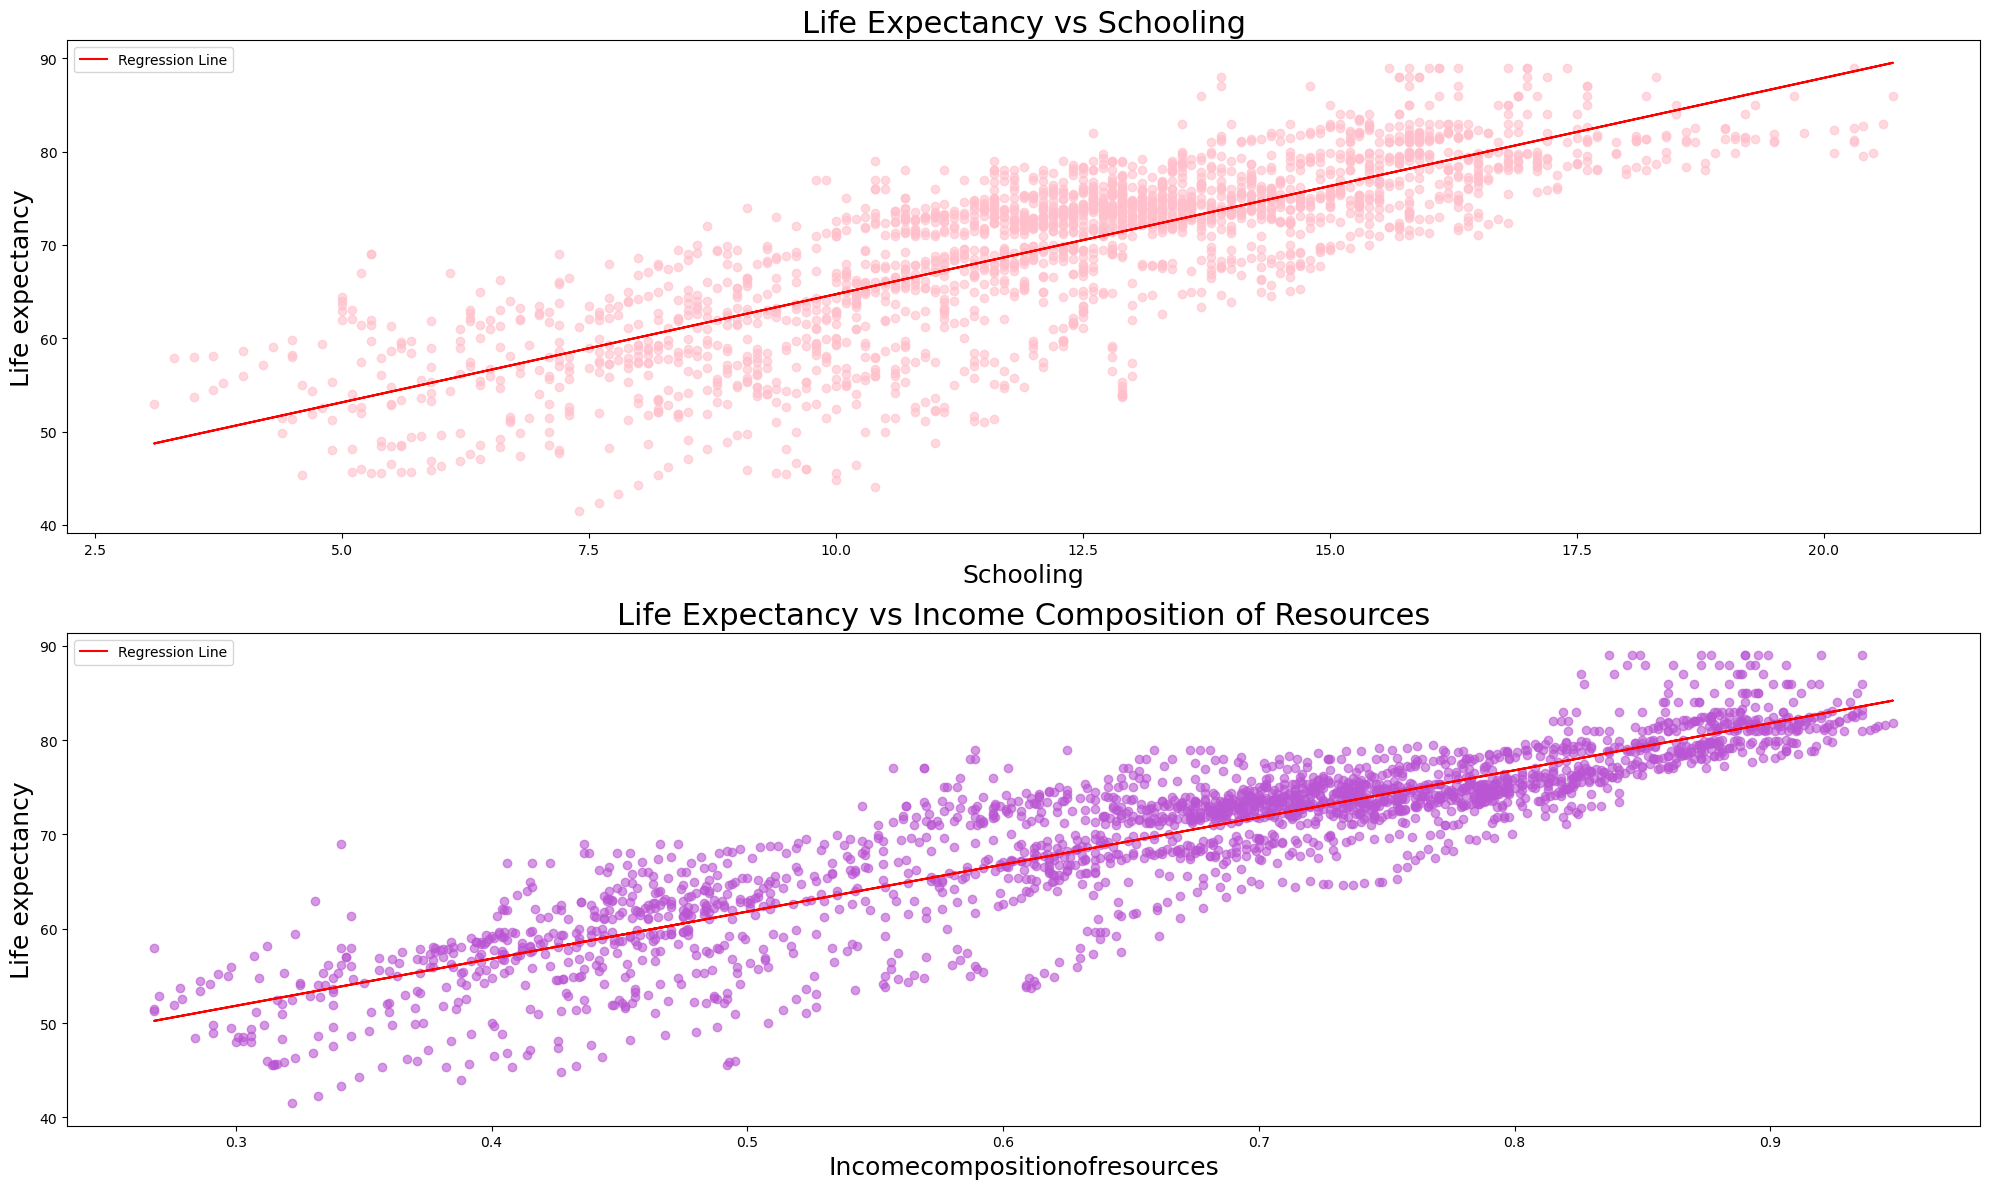

In [246]:
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 1, height_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0, :])
ax1.tick_params(colors='black', which='both')

slope, intercept = np.polyfit(df_cleaned['Schooling'], df_cleaned['Lifeexpectancy'], 1)
ax1.scatter(df_cleaned['Schooling'], df_cleaned['Lifeexpectancy'], alpha=0.6, color='pink')
ax1.plot(df_cleaned['Schooling'], slope * df_cleaned['Schooling'] + intercept, color='r', label='Regression Line')
ax1.set_xlabel('Schooling', color='black', fontsize= 18)
ax1.set_ylabel('Life expectancy', color='black', fontsize= 18)
ax1.set_title('Life Expectancy vs Schooling', color='black', fontsize= 22)
ax1.legend()

ax2 = fig.add_subplot(gs[1, :])
ax2.tick_params(colors='black', which='both')

slope, intercept = np.polyfit(df_cleaned['Incomecompositionofresources'], df_cleaned['Lifeexpectancy'], 1)
ax2.scatter(df_cleaned['Incomecompositionofresources'], df_cleaned['Lifeexpectancy'], alpha=0.6, color='mediumorchid')
ax2.plot(df_cleaned['Incomecompositionofresources'], slope * df_cleaned['Incomecompositionofresources'] + intercept, color='r', label='Regression Line')
ax2.set_xlabel('Incomecompositionofresources', color='black', fontsize= 18)
ax2.set_ylabel('Life expectancy', color='black', fontsize= 18)
ax2.set_title('Life Expectancy vs Income Composition of Resources', color='black', fontsize= 22)
ax2.legend()

plt.tight_layout()
plt.show()


These linear regressions prove that there is a relation between all three variables: Schooling, Income composition and Life expectancy!

In [247]:
warnings.filterwarnings('ignore', category=UserWarning, message='X does not have valid feature names')


model = LinearRegression()

model.fit(df_cleaned[['Schooling']], df_cleaned['Incomecompositionofresources'])

modelIntercept1 = model.intercept_
modelCoef1 = model.coef_[0]

model.fit(df_cleaned[['Incomecompositionofresources']], df_cleaned['Lifeexpectancy'])

modelIntercept2 = model.intercept_
modelCoef2 = model.coef_[0]
markdown_text = f"""
$$
\\text{{Prediction equations:}}\\newline
\\text{{Income composition}} = {modelIntercept1:.2f} + {modelCoef1:.2f} \\cdot \\text{{Schooling}}\\newline
\\text{{Life expectancy}} = {modelIntercept2:.2f} + {modelCoef2:.2f} \\cdot \\text{{Income composition}}
$$
$$ 
\\Longrightarrow \\text{{Life expectancy}} = {(modelIntercept2 + modelCoef2*modelIntercept1):.2f} + {(modelCoef2*modelCoef1):.2f} \\cdot \\text{{Schooling}}
$$
$$
\\text{{which is quite similar to our direct equation from before:}}\\newline
\\text{{Life expectancy}} = {intercept:.2f} + {coef:.2f} \\cdot \\text{{Schooling}}
$$
"""
Markdown(markdown_text)



$$
\text{Prediction equations:}\newline
\text{Income composition} = 0.07 + 0.05 \cdot \text{Schooling}\newline
\text{Life expectancy} = 36.86 + 49.94 \cdot \text{Income composition}
$$
$$ 
\Longrightarrow \text{Life expectancy} = 40.54 + 2.40 \cdot \text{Schooling}
$$
$$
\text{which is quite similar to our direct equation from before:}\newline
\text{Life expectancy} = 36.86 + 2.32 \cdot \text{Schooling}
$$


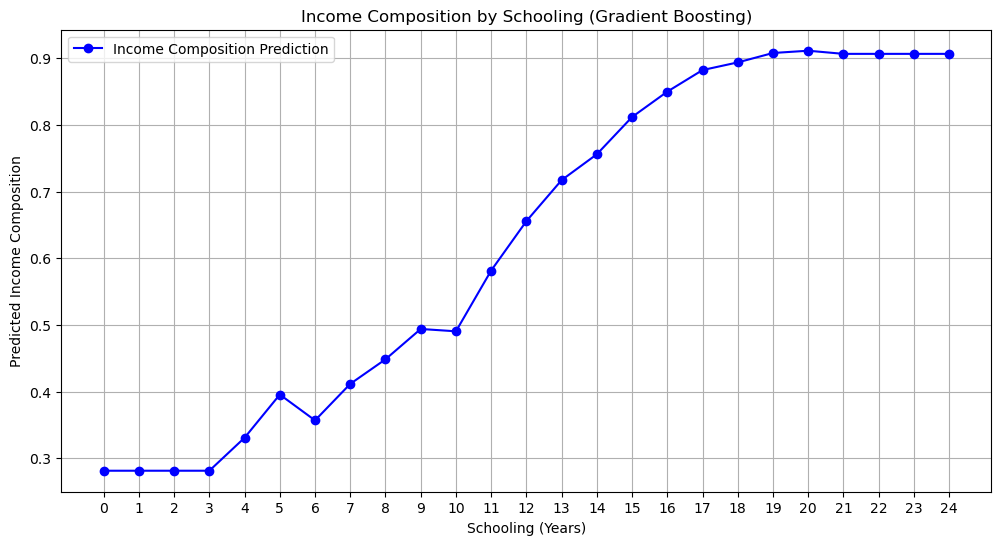

In [248]:
X = df_cleaned[['Schooling']]
y = df_cleaned['Incomecompositionofresources']

gb_model = GradientBoostingRegressor()
gb_model.fit(X, y)

income_results = []
schooling_years = list(range(0, 25, 1))

for years in schooling_years:
    new_data = [[years]]

    income_prediction_gb = gb_model.predict(new_data)[0]
    income_results.append({
        'Schooling (Years)': years,
        'Income Composition': income_prediction_gb
    })

income_df = pd.DataFrame(income_results)

plt.figure(figsize=(12, 6))

plt.plot(income_df['Schooling (Years)'], income_df['Income Composition'], marker='o', color='blue', label='Income Composition Prediction')

plt.title('Income Composition by Schooling (Gradient Boosting)')
plt.xlabel('Schooling (Years)')
plt.ylabel('Predicted Income Composition')
plt.xticks(schooling_years) 
plt.grid()
plt.legend()

plt.show()


In [253]:
X = df_cleaned[['Schooling', 'Incomecompositionofresources']]
y = df_cleaned['Lifeexpectancy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

mse_tree = mean_squared_error(y_test, y_pred_tree)
mse_rf = mean_squared_error(y_test, y_pred_rf)
mse_gb = mean_squared_error(y_test, y_pred_gb)

r2_tree = r2_score(y_test, y_pred_tree)
r2_rf = r2_score(y_test, y_pred_rf)
r2_gb = r2_score(y_test, y_pred_gb)

print(f"Decision Tree - Mean Squared Error: {mse_tree}, R-squared: {r2_tree}")
print(f"Random Forest - Mean Squared Error: {mse_rf}, R-squared: {r2_rf}, Tree depth: {tree_model.get_depth()}")
print(f"Gradient Boosting - Mean Squared Error: {mse_gb}, R-squared: {r2_gb}")

Decision Tree - Mean Squared Error: 25.05448905543659, R-squared: 0.711888211052102
Random Forest - Mean Squared Error: 15.65725951100551, R-squared: 0.8199507865534207, Tree depth: 25
Gradient Boosting - Mean Squared Error: 13.80721071519179, R-squared: 0.841225252259882


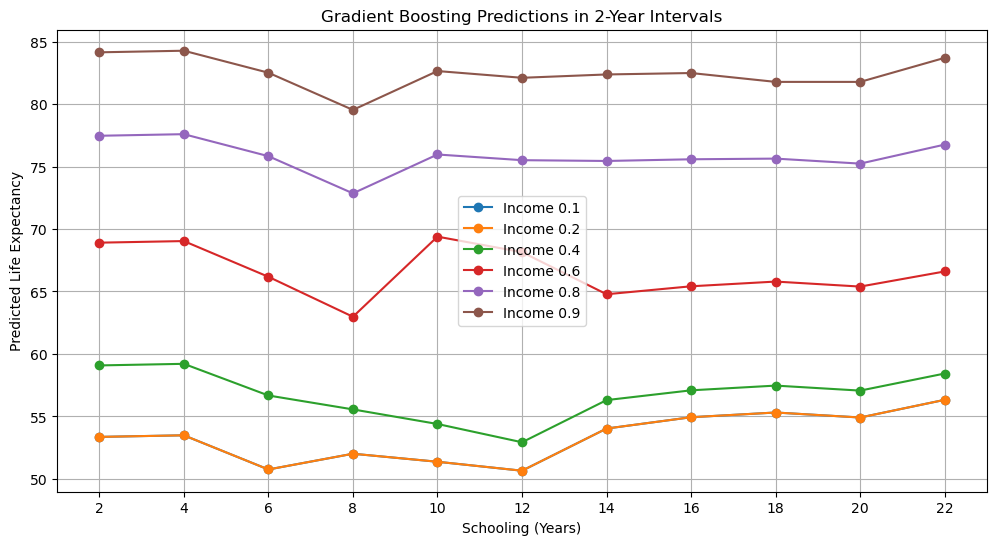

In [250]:
gb_model = GradientBoostingRegressor()

X = df_cleaned[['Schooling', 'Incomecompositionofresources']]
y = df_cleaned['Lifeexpectancy']

gb_model.fit(X, y)

gb_results = []

schooling_years = list(range(2, 23, 2))  # Schooling years in intervals of 2 (2, 4, 6, ..., 22)
income_composition = [0.1, 0.2, 0.4, 0.6, 0.8, 0.9]  # Specify only the desired income composition values

for years in schooling_years:
    for income in income_composition:
        new_data = [[years, income]]

        life_expectancy_gb = gb_model.predict(new_data)[0]
        gb_results.append({
            'Schooling (Years)': years,
            'Income Composition': income,
            'Life Expectancy': life_expectancy_gb
        })

gb_df = pd.DataFrame(gb_results)

plt.figure(figsize=(12, 6))

for income in income_composition:
    subset = gb_df[gb_df['Income Composition'] == income]
    plt.plot(subset['Schooling (Years)'], subset['Life Expectancy'], marker='o', label=f'Income {income}')

plt.title('Gradient Boosting Predictions in 2-Year Intervals')
plt.xlabel('Schooling (Years)')
plt.ylabel('Predicted Life Expectancy')
plt.xticks(schooling_years) 
plt.legend()
plt.grid()

plt.show()


In [251]:
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    mse_scores = -scores
    mean_mse = mse_scores.mean()
    std_mse = mse_scores.std()
    
    r2_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    mean_r2 = r2_scores.mean()
    std_r2 = r2_scores.std()
    
    print(f"{name} - Mean Squared Error: {mean_mse:.2f} (±{std_mse:.2f}), R-squared: {mean_r2:.2f} (±{std_r2:.2f})")


Random Forest - Mean Squared Error: 21.43 (±1.70), R-squared: 0.73 (±0.03)
Gradient Boosting - Mean Squared Error: 17.74 (±2.30), R-squared: 0.77 (±0.03)


In [252]:
print("Feature Importance:\n")
print("- Random Forest")
importances = rf_model.feature_importances_
features = ['Schooling', 'Incomecompositionofresources']
for feature, importance in zip(features, importances):
    print(f"\tFeature: {feature}, Importance: {importance:.4f}")
print("\n- Gradient Boosting")
importances = gb_model.feature_importances_
features = ['Schooling', 'Incomecompositionofresources']
for feature, importance in zip(features, importances):
    print(f"\tFeature: {feature}, Importance: {importance:.4f}")


Feature Importance:

- Random Forest
	Feature: Schooling, Importance: 0.0969
	Feature: Incomecompositionofresources, Importance: 0.9031

- Gradient Boosting
	Feature: Schooling, Importance: 0.0348
	Feature: Incomecompositionofresources, Importance: 0.9652
